# Sales Win Loss

###### Understand your sales pipeline and uncover what can lead to successful sales opportunities and better anticipate performance gaps.

In [25]:
import math
import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('seaborn-whitegrid')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
import statsmodels.api as sm

# 1 Get the Data

In [26]:
df = pd.read_csv('01 WA_Fn-UseC_-Sales-Win-Loss.csv')
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78025 entries, 0 to 78024
Data columns (total 19 columns):
Opportunity Number                         78025 non-null int64
Supplies Subgroup                          78025 non-null object
Supplies Group                             78025 non-null object
Region                                     78025 non-null object
Route To Market                            78025 non-null object
Elapsed Days In Sales Stage                78025 non-null int64
Opportunity Result                         78025 non-null object
Sales Stage Change Count                   78025 non-null int64
Total Days Identified Through Closing      78025 non-null int64
Total Days Identified Through Qualified    78025 non-null int64
Opportunity Amount USD                     78025 non-null int64
Client Size By Revenue                     78025 non-null int64
Client Size By Employee Count              78025 non-null int64
Revenue From Client Past Two Years         78025 non-n

In [27]:
def func_RFC (x):
    if x == 0: return "NO"
    else: return "YES"
df['Revenue_Past_2Years_bin'] = df['Revenue From Client Past Two Years'].apply(func_RFC)

In [28]:
def func_RTM (x):
    if x == "Telecoverage": return "c. Telecoverage"
    elif x in ("Reseller","Telesales"): return "a. Reseller or Telesales"
    else: return "b. Others"
df['Route_Market_bin'] = df['Route To Market'].apply(func_RTM)

In [29]:
def func_DSC (x):
    if x == 1: return "a. 1"
    elif x in (2,3): return "b. 2 or 3"
    else: return "c. Others"
df['Deal_Size_bin'] = df['Deal Size Category'].apply(func_DSC)

In [30]:
def bin_SSCC (x):
    if x <= 2: return "a. <= 2 times"
    else: return "b. > 2 times"
df['Sales_Change_bin'] = df['Sales Stage Change Count'].apply(bin_SSCC)

In [31]:
def TDITQ (x):
    if x < 4: return "a. 0-4"
    elif x < 12: return "b. 4-12"
    elif x < 24: return "c. 12-24"
    else: return "d. 24+"
df['Total_Days_Qualified_bin'] = df['Total Days Identified Through Qualified'].apply(TDITQ)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78025 entries, 0 to 78024
Data columns (total 24 columns):
Opportunity Number                         78025 non-null int64
Supplies Subgroup                          78025 non-null object
Supplies Group                             78025 non-null object
Region                                     78025 non-null object
Route To Market                            78025 non-null object
Elapsed Days In Sales Stage                78025 non-null int64
Opportunity Result                         78025 non-null object
Sales Stage Change Count                   78025 non-null int64
Total Days Identified Through Closing      78025 non-null int64
Total Days Identified Through Qualified    78025 non-null int64
Opportunity Amount USD                     78025 non-null int64
Client Size By Revenue                     78025 non-null int64
Client Size By Employee Count              78025 non-null int64
Revenue From Client Past Two Years         78025 non-n

In [33]:
df = df[['Opportunity Number','Opportunity Result','Sales_Change_bin','Total_Days_Qualified_bin',
         'Deal_Size_bin','Revenue_Past_2Years_bin','Route_Market_bin']].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78025 entries, 0 to 78024
Data columns (total 7 columns):
Opportunity Number          78025 non-null int64
Opportunity Result          78025 non-null object
Sales_Change_bin            78025 non-null object
Total_Days_Qualified_bin    78025 non-null object
Deal_Size_bin               78025 non-null object
Revenue_Past_2Years_bin     78025 non-null object
Route_Market_bin            78025 non-null object
dtypes: int64(1), object(6)
memory usage: 4.8+ MB


# 2.1 Sales_Change_bin

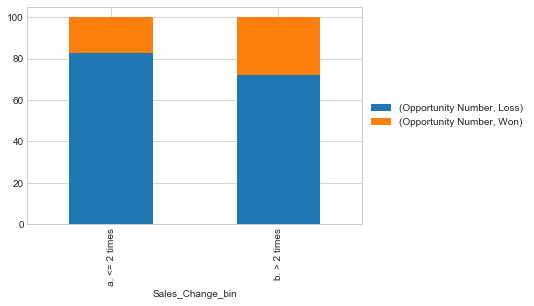

In [34]:
temp = df.pivot_table(values=['Opportunity Number'], index=['Sales_Change_bin'], 
                      columns=['Opportunity Result'], aggfunc='count')
temp = temp.apply(lambda c: c / c.sum() * 100, axis=1)
temp.plot(kind="bar",stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# 2.2 Total_Days_Qualified_bin

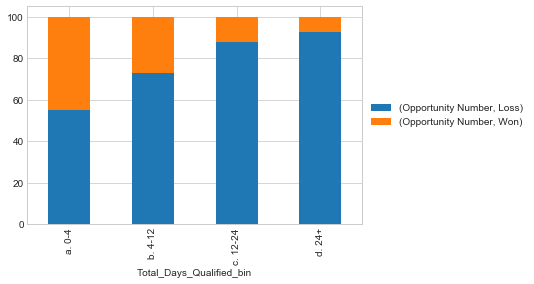

In [35]:
temp = df.pivot_table(values=['Opportunity Number'], index=['Total_Days_Qualified_bin'], 
                      columns=['Opportunity Result'], aggfunc='count')
temp = temp.apply(lambda c: c / c.sum() * 100, axis=1)
temp.plot(kind="bar",stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# 2.3 Deal_Size_bin

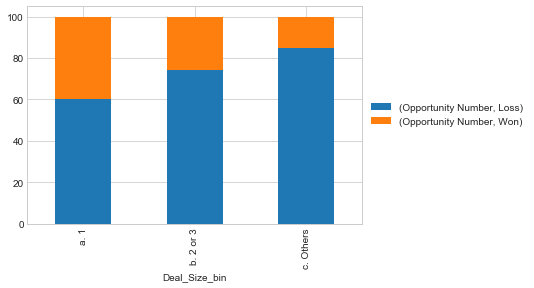

In [36]:
temp = df.pivot_table(values=['Opportunity Number'], index=['Deal_Size_bin'], 
                      columns=['Opportunity Result'], aggfunc='count')
temp = temp.apply(lambda c: c / c.sum() * 100, axis=1)
temp.plot(kind="bar",stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# 2.4 Revenue_Past_2Years_bin

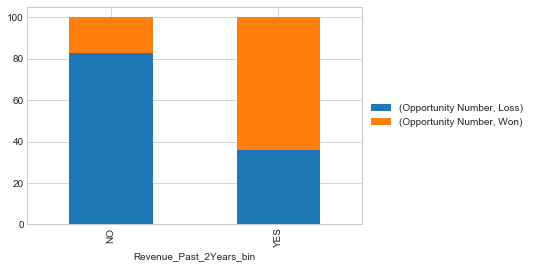

In [37]:
temp = df.pivot_table(values=['Opportunity Number'], index=['Revenue_Past_2Years_bin'], 
                      columns=['Opportunity Result'], aggfunc='count')
temp = temp.apply(lambda c: c / c.sum() * 100, axis=1)
temp.plot(kind="bar",stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# 2.5 Route_Market_bin

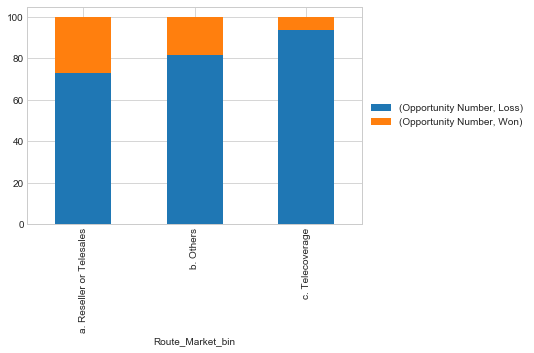

In [38]:
temp = df.pivot_table(values=['Opportunity Number'], index=['Route_Market_bin'], 
                      columns=['Opportunity Result'], aggfunc='count')
temp = temp.apply(lambda c: c / c.sum() * 100, axis=1)
temp.plot(kind="bar",stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# 3 Train Test Split

In [39]:
df['actual'] = df['Opportunity Result'].apply(lambda x: 0 if x == "Loss" else 1)
df.drop(['Opportunity Number','Opportunity Result'],axis=1,inplace=True)

In [40]:
cat_feats = ['Sales_Change_bin','Total_Days_Qualified_bin','Deal_Size_bin','Revenue_Past_2Years_bin','Route_Market_bin']
final_data = pd.get_dummies(df,columns=cat_feats,drop_first=True)

In [41]:
x = final_data.drop(['actual'],axis=1)
y = final_data['actual']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3, random_state=101)

# 4 Building the Model

In [42]:
x_train = sm.add_constant(x_train).copy()
logit = sm.Logit(y_train, x_train)
result = logit.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.377055
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 actual   No. Observations:                54617
Model:                          Logit   Df Residuals:                    54607
Method:                           MLE   Df Model:                            9
Date:                Sat, 18 Nov 2017   Pseudo R-squ.:                  0.2921
Time:                        23:17:52   Log-Likelihood:                -20594.
converged:                       True   LL-Null:                       -29090.
                                        LLR p-value:                     0.000
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                 0.0059      0.033      0.178      0.859      -0.059       0.070
Sales_Change_bin_b. > 2 times         1.3816      0.028     49.548      0.000       1.327       1.436
Total_Days_Qualified_bin_b. 4-12     -1.0618      0.031    -33.711      0.000      -1.124      -1.000
Total_Days_Qualified_bin_c. 12-24    -2.2504      0.038    -59.580      0.000      -2.324      -2.176
Total_Days_Qualified_bin_d. 24+      -2.9472      0.044    -67.307      0.000      -3.033      -2.861
Deal_Size_bin_b. 2 or 3              -0.6090      0.033    -18.210      0.000      -0.675      -0.543
Deal_Size_bin_c. Others              -1.2265      0.034    -35.876      0.000      -1.294      -1.160
Revenue_Past_2Years_bin_YES           2.3664      0.035     66.944      0.000       2.297       2.436
Route_Market_bin_b. Others           -0.5880      0.026    -22.227      0.000      -0.640      -0.536
Route_Market_bin_c. Telecoverage     -1.6607      0.210     -7.900      0.000      -2.073      -1.249
=====================================================================================================
"""

In [43]:
x_test = sm.add_constant(x_test).copy()
y_pred = result.predict(x_test)
x_test = x_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
y_pred = y_pred.reset_index(drop=True)
test_calc = pd.concat([x_test,y_test,pd.DataFrame(y_pred)],axis=1)
test_calc.rename(columns={0: 'predicted'}, inplace=True)

max c:  0.3
max a:  0.45


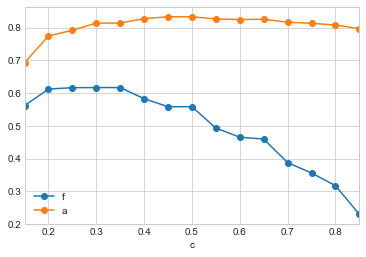

In [44]:
c = [0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85]
a = [0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85]
p = [0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85]
r = [0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85]
f = [0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85]
i = 0

for j in c:
    def flag(cols):
        x = cols[0]
        j = cols[1]
        if x > j: return 1
        else: return 0
    test_calc['j']=j
    test_calc['flag'] = test_calc[['predicted','j']].apply(flag,axis=1)
    df_table = confusion_matrix(test_calc['actual'],test_calc['flag'])
    a[i] = (df_table[0,0] + df_table[1,1]) / (df_table[0,0] + df_table[0,1] + df_table[1,0] + df_table[1,1])
    p[i] = df_table[1,1] / (df_table[1,1] + df_table[0,1])
    r[i] = df_table[1,1] / (df_table[1,1] + df_table[1,0])
    f[i] = (2 * p[i] * r[i]) / (p[i] + r[i])
    i = i+1

df_decision = pd.concat([pd.DataFrame(c),pd.DataFrame(a),pd.DataFrame(p),pd.DataFrame(r),pd.DataFrame(f)],axis=1)
df_decision.columns = ['c','a','p','r','f']

f_max = df_decision[df_decision['f']==df_decision['f'].max()].head(1)
max_c = float(f_max['c'])
a_max = df_decision[df_decision['a']==df_decision['a'].max()].head(1)
max_a = float(a_max['c'])

df_decision.plot(x='c',y=['f','a'],marker="o")

print ("max c: ",max_c)
print ("max a: ",max_a)

# 5 Predictions and Evaluation

In [45]:
test_calc['predicted'] = test_calc['predicted'].apply(lambda x: 1 if x > 0.3 else 0)
df_table = confusion_matrix(test_calc['actual'],test_calc['predicted'])
print (df_table)

print('accuracy:', (df_table[0,0] + df_table[1,1]) / (df_table[0,0] + df_table[0,1] + df_table[1,0] + df_table[1,1]))
print ('precision:', df_table[1,1] / (df_table[1,1] + df_table[0,1]))
print('recall:', df_table[1,1] / (df_table[1,1] + df_table[1,0]))

p = df_table[1,1] / (df_table[1,1] + df_table[0,1])
r = df_table[1,1] / (df_table[1,1] + df_table[1,0])
print('f1 score: ', (2*p*r)/(p+r))

[[15538  2508]
 [ 1852  3510]]
accuracy: 0.813738892686
precision: 0.583250249252
recall: 0.654606490116
f1 score:  0.616871704745
